In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset, random_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import cv2
import torchvision
from torchvision import transforms as T
from torchvision import datasets, models
from torchvision.datasets import ImageFolder

from torchmetrics.classification import MulticlassJaccardIndex

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

import segmentation_models_pytorch as smp

import wandb

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
wandb.login()

## EDA
### First let's take a look at how pictures and their corresponding masks look like

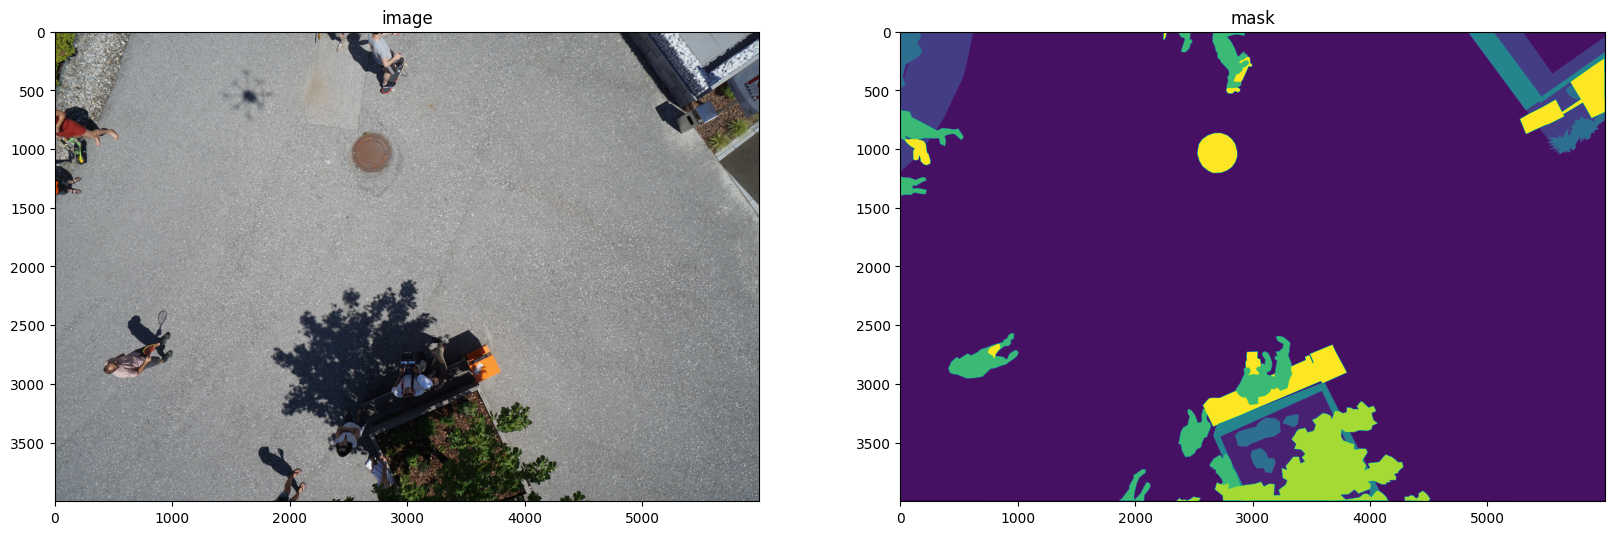

In [2]:
img = cv2.imread("/semantic_drone_dataset/original_images/000.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread("/semantic_drone_dataset/label_images_semantic/000.png", cv2.IMREAD_GRAYSCALE)

figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(img)
ax1.set_title("image")

ax2.imshow(mask)
ax2.set_title("mask")

figure.show()

### As we can see, pictures are in very high resolution (4000x6000), so resize is required
### You can also see that there is a lot of fine details in the pictures and it is likely that the class imbalance is quite strong

In [3]:
pixels = []
path = '/semantic_drone_dataset/label_images_semantic'
for filename in os.listdir(path): # to check class distribution we will flatten each mask in dataset into a 1d vector and add to list
    img_path = os.path.join(path, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.flatten()
    pixels.append(img)

In [4]:
pixels = np.concatenate(pixels)
len(pixels)

9600000000

### Data are highly inbalanced, so it will be better to check model quality by using macro mIoU:

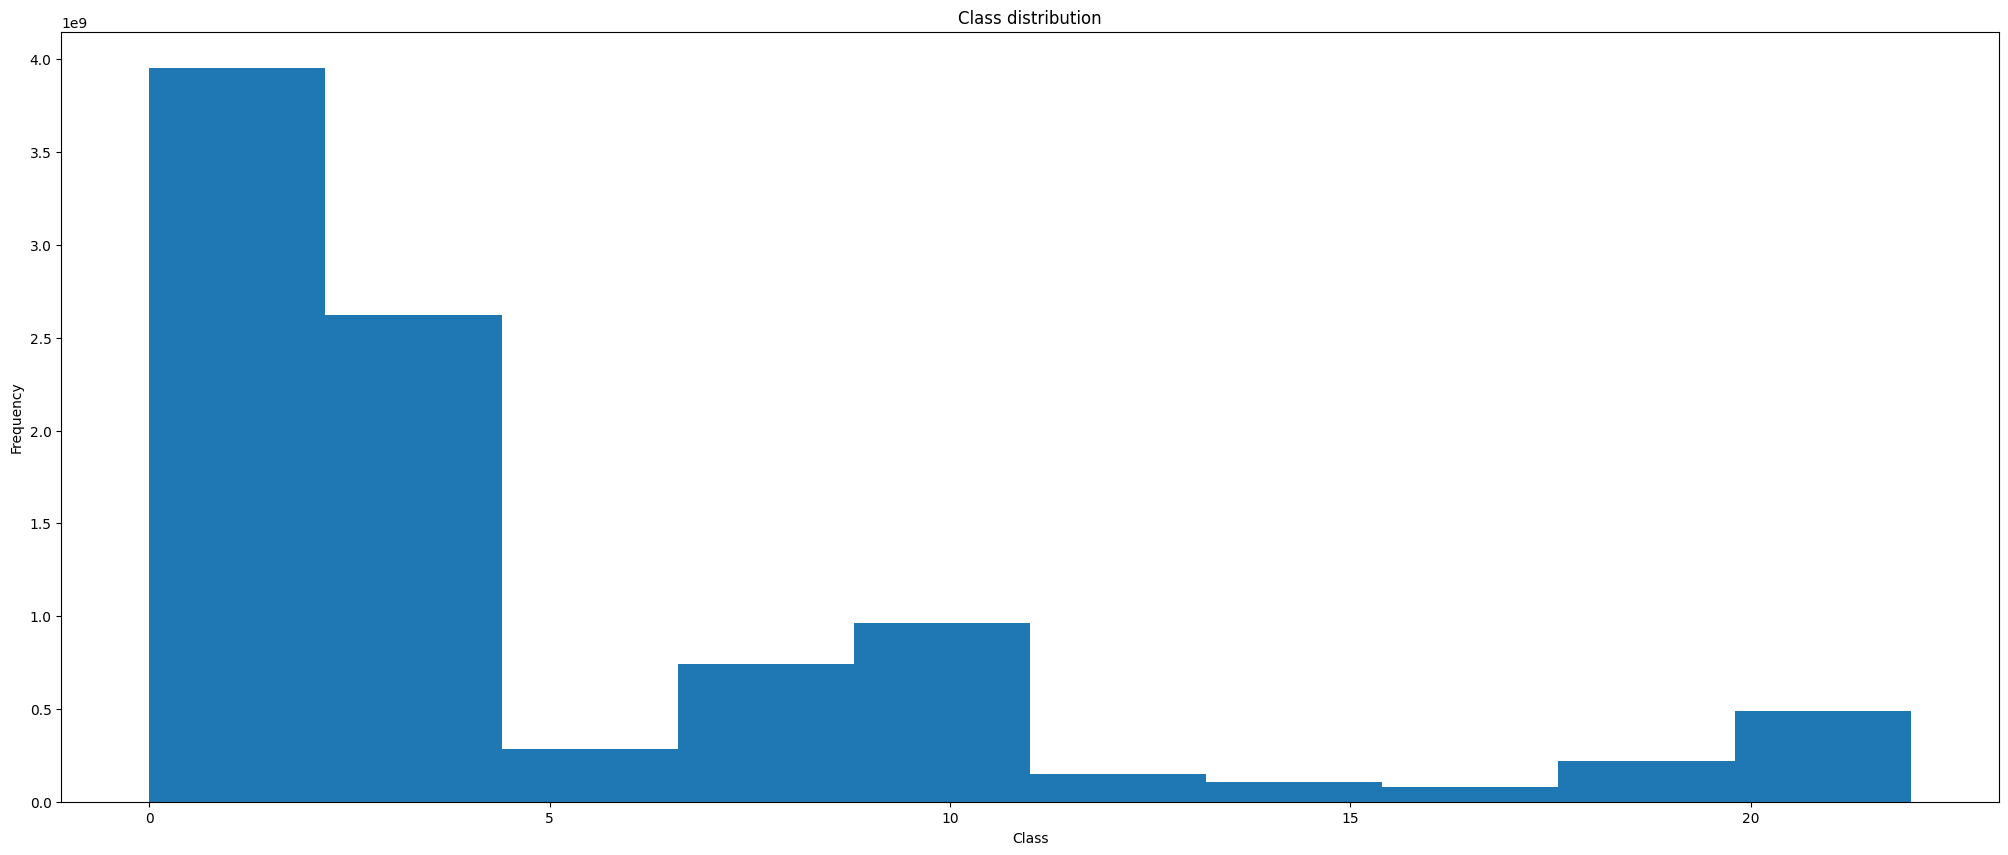

In [5]:
plt.figure(figsize = (25, 10))
plt.hist(pixels)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class distribution')
plt.show()

## Custom dataset specification

In [4]:
# To enable the custom dataset to refer to the names of pictures and masks, create a list of them
img_names = []
path = '/semantic_drone_dataset/original_images'
for filename in os.listdir(path):
    img_names.append(filename[:-4])
    
img_names = pd.DataFrame(img_names) # convert to DataFrame for convenience
img_names

,0
0,208
1,473
2,014
3,537
4,275
...,...
395,461
396,136
397,454
398,040


In [5]:
train, val = train_test_split(img_names, test_size = 0.1, random_state = 42, shuffle = True)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, csv, transform = None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.csv = csv
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_path, self.csv.iloc[idx, 0]) + '.jpg'
        mask_path = os.path.join(self.mask_path, self.csv.iloc[idx, 0]) + '.png'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image = img, mask = mask)
            img = aug["image"]
            mask = aug["mask"]
            
        img = img.float()
        mask = mask.long()
        
        return img, mask

In [7]:
transforms_train = A.Compose([
    A.Resize(352, 512), # U-net architecture requires the image shape to be divided by 32
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.2), # augmentation for better results
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
transforms_val = A.Compose([
    A.Resize(352, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


In [8]:
img_path = '/semantic_drone_dataset/original_images'
mask_path = '/semantic_drone_dataset/label_images_semantic'

train_dataset = CustomDataset(img_path = img_path, mask_path = mask_path, csv = train, transform = transforms_train)
val_dataset = CustomDataset(img_path = img_path, mask_path = mask_path, csv = val, transform = transforms_val)

trainloader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
valloader = DataLoader(val_dataset, batch_size = 8, shuffle = True)

## Model specification

### We will fine-tune U-net model with efficientnet-b1 backbone, pretrained on ImageNet

In [9]:
model = smp.Unet(
    encoder_name="efficientnet-b1",        
    encoder_weights="imagenet",                  
    classes=23
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 147MB/s] 


## Train

In [ ]:
model = nn.DataParallel(model) # model was trained on 2 GPU's
model.to(device)
mIoU = MulticlassJaccardIndex(num_classes=23, average = "macro").to(device) # macro mIoU

wandb.init(project="Drone_segmentation", name="training_run_2")
wandb.watch(model)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
num_epoch = 70

best_model_wts = model.state_dict()
best_mIoU = 0.0

for epoch in range(num_epoch):
    running_loss_train = 0
    processed_data_train = 0
    running_loss_val = 0
    processed_data_val = 0
    predicted = []
    true = []
    model.train()
    for data, target in tqdm(trainloader, total = len(trainloader)):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        probs = model(data)
        loss = criterion(probs, target)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * data.size(0)
        processed_data_train += data.size(0)
    train_loss = running_loss_train / processed_data_train
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(valloader, total = len(valloader)):
            data = data.to(device)
            target = target.to(device)
            probs = model(data)
            loss = criterion(probs, target)
            running_loss_val += loss.item() * data.size(0)
            processed_data_val += data.size(0)
            predicted.append(probs)
            true.append(target)
        val_loss = running_loss_val / processed_data_val
        
        val_mIoU = mIoU(torch.cat(predicted), torch.cat(true))
        
        if val_mIoU > best_mIoU:
                best_mIoU = val_mIoU
                best_model_wts = model.state_dict()
    
    with torch.no_grad():
        track_image_examples()
        
    wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'mIoU': val_mIoU
        })
    # not necessary as we are tracking via wandb
    #print("Epoch" + " " + str(epoch) + ":", "train_loss:" + str(train_loss), "val_loss:" + str(val_loss), "val_mIoU:" + str(val_mIoU))
    scheduler.step()
wandb.finish()